In [2]:
%load_ext autoreload
%autoreload 2
from imports.data import *
from imports.params import p
from imports.utility import *
import matplotlib.pyplot as plt

# add noise

In [23]:
bgd_dict = {}
total_bgd = np.loadtxt(p["model_path"]+"bgd.txt", delimiter=",")
bgd_low = total_bgd[total_bgd[:,0] < 2.3]
bgd_high = total_bgd[total_bgd[:,0] >= 2.3]
bgd_low = np.trapz(bgd_low[:,1], bgd_low[:,0]) * p["modules"]
bgd_high = np.trapz(bgd_high[:,1], bgd_high[:,0]) * p["modules"]
bgd_dict["bgd_low"] = bgd_low #counts / s / arcmin^2
bgd_dict["bgd_high"] = bgd_high

bgd_dict["z015"] = {}
p["redshift"] = 0.15
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
flux_ratio, fov = get_flux_ratio(p)
bgd_dict["z015"]["flux_ratio"] = flux_ratio
bgd_dict["z015"]["fov"] = fov

bgd_dict["z05"] = {}
p["redshift"] = 0.5
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
flux_ratio, fov = get_flux_ratio(p)
bgd_dict["z05"]["flux_ratio"] = flux_ratio.tolist()
bgd_dict["z05"]["fov"] = fov

import json
with open(p['model_path'] + "bgd.json", 'w') as filepath:
    json.dump(bgd_dict, filepath, indent=4)

In [11]:
### save noisy dataset
# for model in ["HYDRO_FIDUCIAL", "HYDRO_JETS_published", "HYDRO_STRONG_AGN", "HYDRO_STRONG_JETS_published", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_STRONGEST_AGN", "HYDRO_WEAK_AGN"]:
for model in ["HYDRO_FIDUCIAL"]:
    p["redshift"] = 0.5
    p["model"] = model
    data = Data(p)
    filename = p_to_filename(p)
    data.load_dataset(filename=filename)
    # halo_i = 0
    # print(np.log10(data.masses[halo_i]))
    # plt.imshow(data.images[halo_i, 0])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(data.images[halo_i, 1])
    # plt.colorbar()
    # plt.show()
    noisy_images = data.add_noise(data.images)
    
    # plt.imshow(noisy_images[halo_i, 0])
    # plt.colorbar()
    # plt.show()
    # plt.imshow(noisy_images[halo_i, 1])
    # plt.colorbar()
    # plt.show()
    np.save(p["data_path"] + filename + "_noisy", noisy_images)
    print(model, "done")

HYDRO_FIDUCIAL done


In [4]:
print(np.trapz(bgd_high[:,1], bgd_high[:,0])*7)

0.002353619822861287


low thermal noise 0.004020065710809641
high thermal nonise 0.002353619822861287


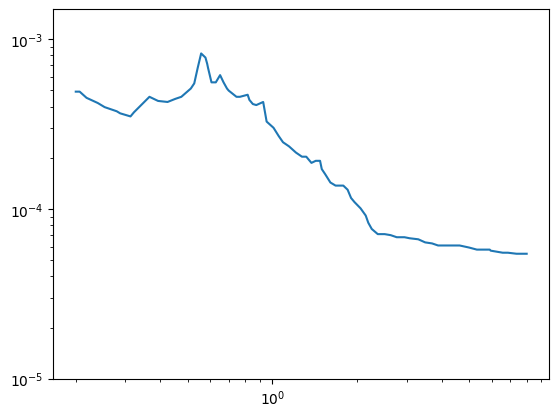

In [21]:
total_bgd = np.loadtxt(p["model_path"]+"bgd.txt", delimiter=",")
bgd_low = total_bgd[total_bgd[:,0] < 2.3]
bgd_high = total_bgd[total_bgd[:,0] >= 2.3]
bgd_cps_low = np.sum(np.diff(bgd_low[:,0]) * (bgd_low[:-1,1] + bgd_low[1:,1])/2)*7
bgd_cps_high = np.sum(np.diff(bgd_high[:,0]) * (bgd_high[:-1,1] + bgd_high[1:,1])/2)*7
print("low thermal noise", bgd_cps_low)
print("high thermal nonise", bgd_cps_high)
plt.plot(total_bgd[:, 0], total_bgd[:, 1])
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-5, 1.5e-3)
plt.show()

In [3]:
z = 0.15
H0 = 70 #km/s/Mpc
c = 3e5 #km/s
r = c*z/H0 * 3.08567758e22 / (1+z) #m
telescope_diameter = 0.36 #m
telescope_surface = np.pi * (telescope_diameter/2)**2 * 7 #m^2
flux_ratio = telescope_surface / (4*np.pi*r**2*(1+z)) #frac of luminosity that arrives at distance r on telescope surface
fov = (np.arcsin(4*3e22/r)/2/np.pi*360*60)**2 #arcmin^2
print(fov)
exposure_time = 100000 #s

571.9827182297263


In [23]:
print((bgd_cps_low*fov*exposure_time)/(64*64))
print(bgd_cps_high*fov*exposure_time /(64*64))

8.595665854712461
5.03248727799244


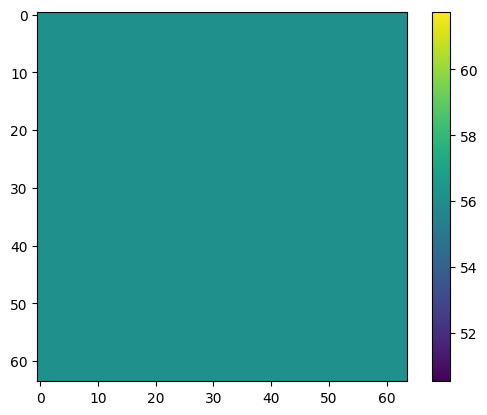

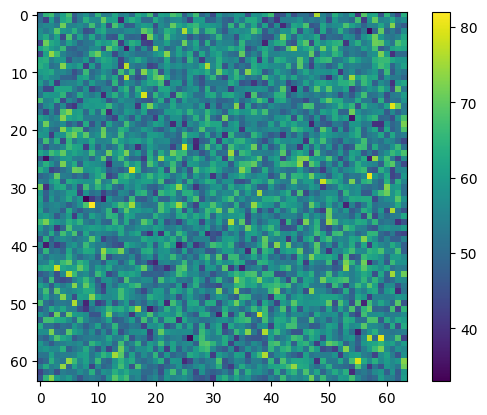

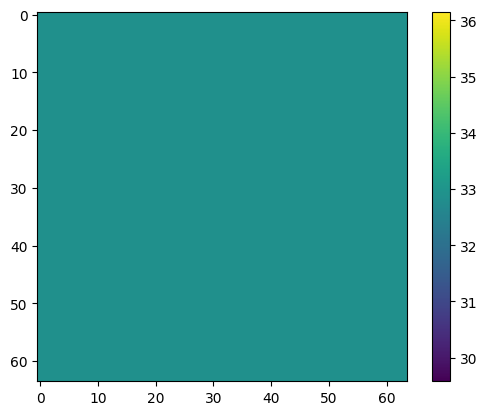

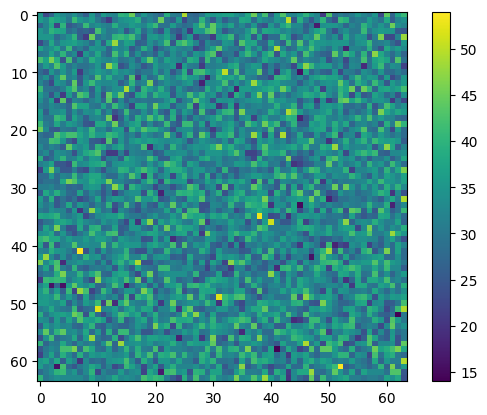

In [204]:
fov = (np.arcsin(4*3e22/r)/2/np.pi*360*60)**2 #arcmin^2
norm_bgd_low = np.ones((64, 64)) / (64*64)*bgd_cps_low*fov*exposure_time
plt.imshow(norm_bgd_low)
plt.colorbar()
plt.show()
plt.imshow(np.random.poisson(norm_bgd_low))
plt.colorbar()
plt.show()
norm_bgd_high = np.ones((64, 64)) / (64*64)*bgd_cps_high*fov*exposure_time
plt.imshow(norm_bgd_high)
plt.colorbar()
plt.show()
plt.imshow(np.random.poisson(norm_bgd_high))
plt.colorbar()
plt.show()

8.65625


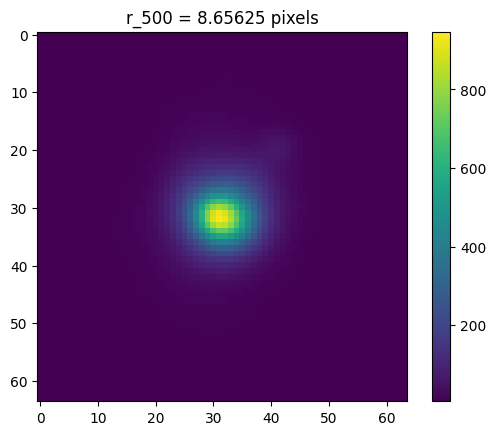

5.90625


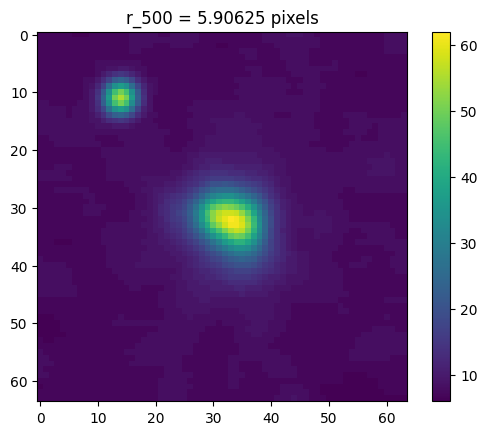

9.515625


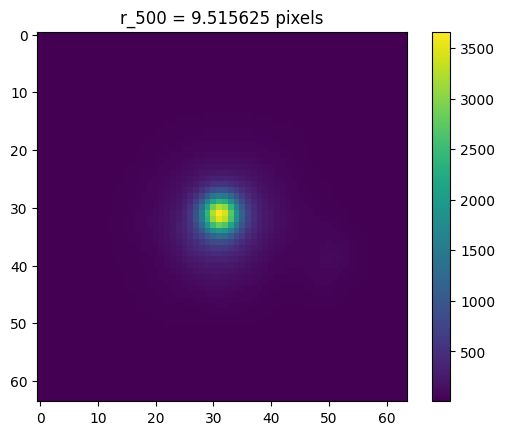

In [57]:
### contributie van background noise op scaling relation, met circular mask op crit500 radius
pixel_size = 4 * 1000 / 64  #kpc
radii = []
p["redshift"] = 0.5
data = Data(p)
data.load_dataset(filename=p_to_filename(p))
data.image_to_observation()


lums_low = []
lums_high = []
for i, haloindex in enumerate(data.indices[:3]):
    norm_bgd_low = np.random.poisson(np.ones((64, 64)) / (64*64)*bgd_cps_low*fov*exposure_time*7)
    norm_bgd_high = np.random.poisson(np.ones((64, 64)) / (64*64)*bgd_cps_high*fov*exposure_time*7)
    # norm_bgd_low = np.random.poisson(np.ones((64, 64)) *273)
    # norm_bgd_high = np.random.poisson(np.ones((64, 64)) *50)
    r = data.soap_file[f"SO/500_crit/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    radii.append(radius)
    X, Y = np.ogrid[:p['resolution'], :p['resolution']]
    dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
    mask_circle = dist_from_center<=radius
    lums_low.append(np.log10(np.abs(np.sum(norm_bgd_low[mask_circle]))))
    lums_high.append(np.log10(np.abs(np.sum(norm_bgd_high[mask_circle]))))
    print(radius)
    plt.imshow(data.images[i, 0])
    plt.colorbar()
    plt.title(f"r_500 = {radius} pixels")
    plt.show()

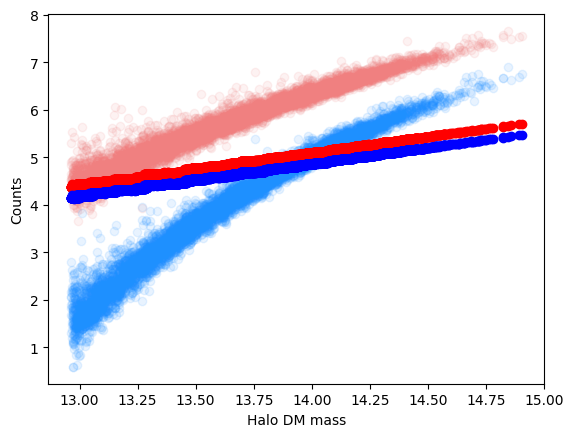

In [208]:
plt.scatter(np.log10(data.soap_file[f"{data.selection_type}/DarkMatterMass"][np.sort(data.indices)]), np.log10(data.soap_file[f"{data.selection_type}/XRayPhotonLuminosityWithoutRecentAGNHeating"][np.sort(data.indices),0] * flux_ratio * exposure_time), c="lightcoral", alpha=0.1, label="Signal counts low")
plt.scatter(np.log10(data.soap_file[f"{data.selection_type}/DarkMatterMass"][np.sort(data.indices)]), np.log10(data.soap_file[f"{data.selection_type}/XRayPhotonLuminosityWithoutRecentAGNHeating"][np.sort(data.indices),1] * flux_ratio * exposure_time), c="dodgerblue", alpha=0.1, label="Signal counts high")
plt.scatter(np.log10(data.masses), lums_low, c="red", label="Background counts low")
plt.scatter(np.log10(data.masses), lums_high, c="blue", label="Background counts high")
plt.xlabel("Halo DM mass")
plt.ylabel("Counts")
plt.show()

image arcmin across:  21.814649841129103
avg z:  0.14328846153846156
avg flux:  3.2112500000000003e-15
counts:  47587.8947691074
counts2:  20.0
thermal instrument counts:  27329.49485870088
thermal instrument counts:  16000.544636686875
thermal instrument counts:  6.67223995573752
thermal instrument counts:  3.9063829679411315


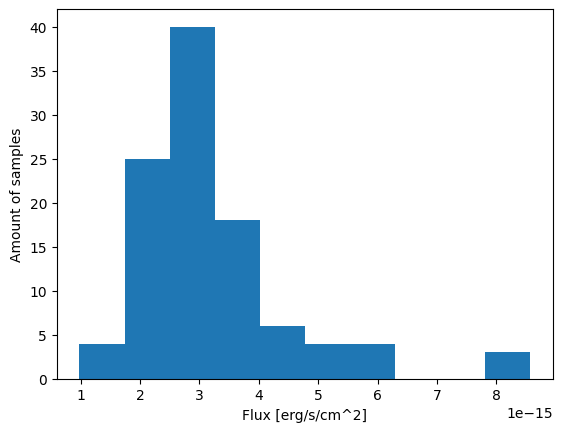

In [28]:
# xmm_corrected = np.loadtxt(p["model_path"]+"XMM-ROSAT_bgd.txt", skiprows=1, usecols=(4))[:-16] #erg/s/cm^2
# rosat_bg = np.loadtxt(p["model_path"]+"XMM-ROSAT_bgd.txt", skiprows=1, usecols=(5)) #erg/s/cm^2
# samples = np.append(xmm_corrected, rosat_bg)
# zs = np.loadtxt(p["model_path"]+"XMM-ROSAT_bgd.txt", skiprows=1, usecols=(1))
# zs = np.append(zs[:-16], zs)

# arcmin = (np.arcsin(4*3e22/r)/2/np.pi*360*60)
# print("image arcmin across: ", arcmin)
# print("avg z: ", np.mean(zs))
# print("avg flux: ", np.mean(samples))


# ### counts/s
# print("counts: ", 1.0e-3 * exposure_time*arcmin**2)
# print("counts2: ", 2e-4 * exposure_time)

# instrument_counts = 0.00032913537467356207 #counts/s/kev/arcmin^2
# print("thermal instrument counts: ", thermal_cps_low * exposure_time * arcmin**2)
# print("thermal instrument counts: ", thermal_cps_high * exposure_time * arcmin**2)
# print("thermal instrument counts: ", thermal_cps_low * exposure_time * arcmin**2 / (64*64))
# print("thermal instrument counts: ", thermal_cps_high * exposure_time * arcmin**2 / (64*64))

# # print((np.arcsin(4*3e22/r)/2/np.pi * 360*60)**2)
# # print(1/(zs*c/H0*3.08567758e22)**2*r**2)
# # print(samples * exposure_time * (8-2.3) * (np.arcsin(4*3e22/r)/2/np.pi*360*60)**2 * (64*64) / (zs*c/H0*3.08567758e22)**2*r**2)#bg * s * kev * arcmin^2
# plt.hist((samples))
# plt.xlabel("Flux [erg/s/cm^2]")
# plt.ylabel("Amount of samples")
# plt.show()

[[365.49399681 362.26929787 393.36938347 ... 378.79334483 381.11224365
  340.8221497 ]
 [386.60487285 313.95297884 359.33773573 ... 360.06301612 386.42907795
  378.45372914]
 [405.31808396 378.9553584  355.1053702  ... 339.29528385 404.12547608
  435.17397761]
 ...
 [379.06453282 389.09992385 399.77620075 ... 387.86013583 367.56108174
  367.54827807]
 [408.04251958 387.832782   396.13850275 ... 378.02845578 451.14571777
  350.50524406]
 [390.69635516 353.00129438 397.72750921 ... 360.0167238  396.24837314
  375.71614814]]
1543170.9770945027


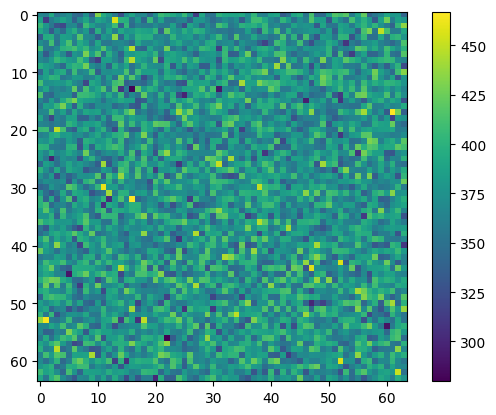

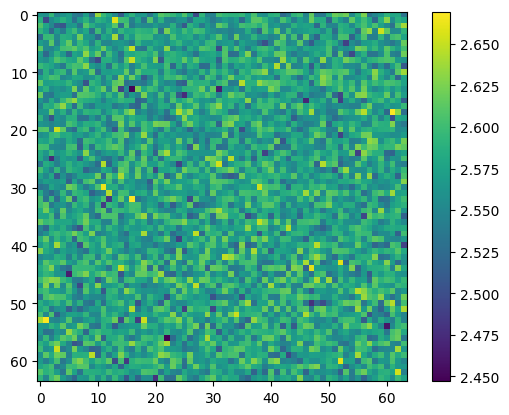

In [67]:
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
filename = p_to_filename(p)
photon_counts = np.load(p["data_path"]+"/z0/" + filename + "_photons.npy")
i = 2902
print(photon_counts[i, 1])
print(np.sum(photon_counts[i, 1]))
plt.imshow(photon_counts[i, 1])
plt.colorbar()
plt.show()
plt.imshow(np.log10(photon_counts[i, 1]))
plt.colorbar()
plt.show()

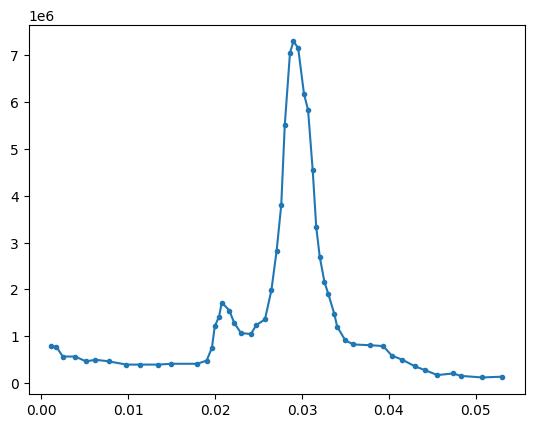

In [27]:
from scipy.optimize import curve_fit
noisedata = np.loadtxt(p["model_path"]+"background_counts.txt", delimiter=",")
plt.plot(noisedata[:,0], noisedata[:,1], marker=".")
plt.show()

In [28]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [7*1e6, 0.03, 0.01]
coeff, var_matrix = curve_fit(gauss, noisedata[:,0], noisedata[:,1], p0=p0)
print(coeff)

[6.94999874e+06 2.94732021e-02 2.02338343e-03]


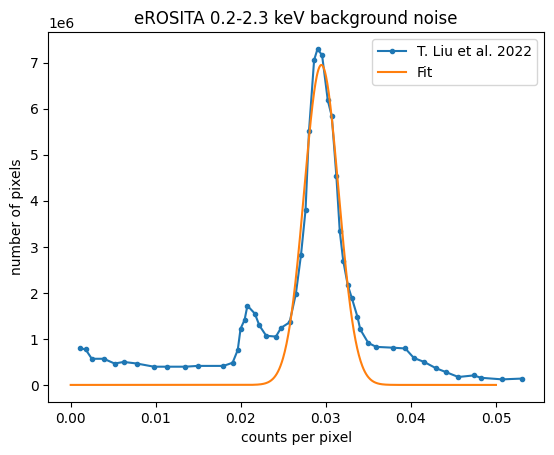

In [29]:
x = np.linspace(0, 0.05, 1000)
plt.plot(noisedata[:,0], noisedata[:,1], marker=".", label="T. Liu et al. 2022")
plt.plot(x, gauss(x, coeff[0], coeff[1], coeff[2]), label="Fit")
plt.xlabel("counts per pixel")
plt.ylabel("number of pixels")
plt.title("eROSITA 0.2-2.3 keV background noise")
plt.legend()
plt.savefig("Background_noise_fit", dpi=200)
plt.show()

In [30]:
erosita_pixels = 384
erosita_radius = 0.358/2 #m
erosita_exposure_depth = 2200 #s
telescope_radius = 0.5 #m

pixelratio = (erosita_pixels*erosita_pixels) / (p["resolution"]*p["resolution"])
surface_ratio = (np.pi*(telescope_radius)**2)/(np.pi*erosita_radius**2)
exposure_ratio = exposure_time / erosita_exposure_depth
ratio = pixelratio*surface_ratio*exposure_ratio

print(ratio)


12767.732252142852


In [31]:
print(ratio*coeff[1], ratio*coeff[2])

376.3059535060805 25.834017895453567


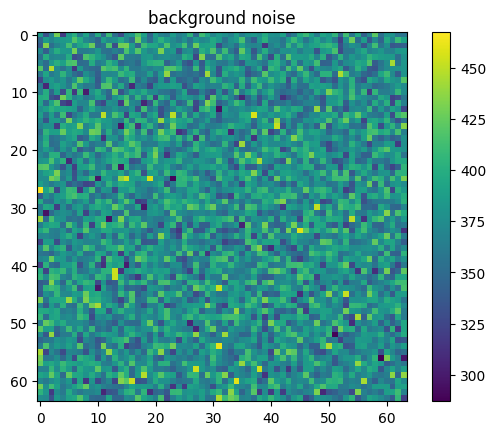

In [7]:
plt.imshow(np.random.normal(loc=coeff[1]*ratio, scale=coeff[2]*ratio, size=(p["resolution"], p["resolution"])))
plt.title("background noise")
plt.colorbar()
plt.show()

In [29]:
for model in ["HYDRO_FIDUCIAL", "HYDRO_JETS_published", "HYDRO_STRONG_AGN", "HYDRO_STRONG_JETS_published", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_STRONGEST_AGN", "HYDRO_WEAK_AGN"]:
    p["model"] = model
    # p["soapfile"] = "halo_properties_0078.hdf5"
    # p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
    # p["snapshot_folder"] = "snapshots_reduced"
    # p["simsize"] = "L2800N5040"
    data = Data(p)
    filename = p_to_filename(p)
    data.load_dataset(filename=filename)
    norm_images = data.images / np.sum(data.images, axis=(2, 3))[:,:,np.newaxis, np.newaxis]
    photon_luminosities = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][()][data.indices, :2] #/s

    # print(photon_luminosities)

    photon_counts = np.random.poisson(norm_images * photon_luminosities[:, :, np.newaxis, np.newaxis] * flux_ratio * exposure_time)
    background_noise = np.ones_like(photon_counts, dtype=float)
    background_noise[:, 0, :, :] *= 1/(64*64)*bgd_cps_low*fov*exposure_time
    background_noise[:, 1, :, :] *= 1/(64*64)*bgd_cps_high*fov*exposure_time
    background_noise = np.random.poisson(background_noise)
    photon_counts[photon_counts == 0] = 1

    np.save(p["data_path"] + filename + "_photons", photon_counts+background_noise)
    print(model, "done")

# plt.imshow(np.log10(photon_counts[-1, 1]))
# plt.colorbar()
# plt.show()


In [8]:
print(np.argmin(data.masses))

2902


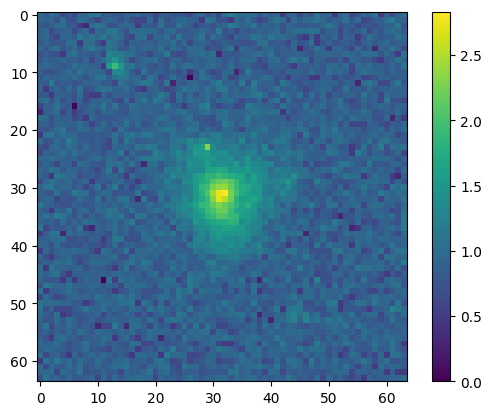

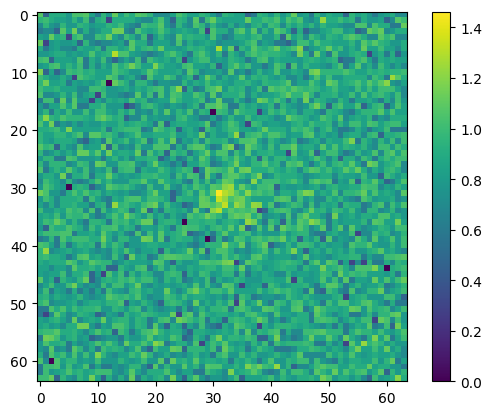

In [28]:
plt.imshow(np.log10(photon_counts+background_noise)[0, 0])
plt.colorbar()
plt.show()
plt.imshow(np.log10(photon_counts+background_noise)[2902, 0])
plt.colorbar()
plt.show()

# test saved data

In [20]:
p["channel"] = "2chan"
p["redshift"] = 0.15
p["noisy"] = False
p["simtype"] = "single"
# p["soapfile"] = "halo_properties_0078.hdf5"
# p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
# p["snapshot_folder"] = "snapshots_reduced"
# p["simsize"] = "L2800N5040"
p["model"] = "HYDRO_STRONGEST_AGN"
data = Data(p)
filename = p_to_filename(p)
data.load_dataset(filename=filename)
print(data.images.shape)
print(data.masses.shape)
print(data.indices.shape)

(7290, 2, 64, 64)
(7290,)
(7290,)


In [21]:
print(np.where(data.soap_file["SO/500_crit/XRayPhotonLuminosityWithoutRecentAGNHeating"][:][data.indices] == 0))

(array([], dtype=int64), array([], dtype=int64))


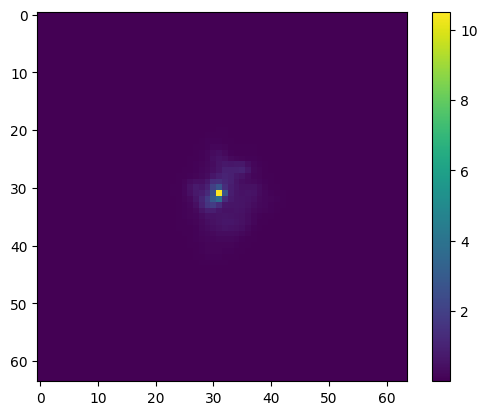

In [22]:
plt.imshow(data.images[3302, 1])
plt.colorbar()
plt.show()

In [19]:
def image_index_remove(index):
    filename = p_to_filename(p)
    oldimages = np.load(p["data_path"] + filename + ".npy")
    oldimages_noisy = np.load(p["data_path"] + filename + "_noisy.npy")
    oldindices = np.load(p["data_path"] + filename + "_halo_indices.npy")
    oldmasses = np.load(p["data_path"] + filename + "_masses.npy")
    newimages = np.delete(oldimages, index, axis=0)
    newimage_noisy = np.delete(oldimages_noisy, index, axis=0)
    newindices = np.delete(oldindices, index)
    newmasses = np.delete(oldmasses, index)
    np.save(p["data_path"] + filename + ".npy", newimages)
    np.save(p["data_path"] + filename + "_noisy.npy", newimage_noisy)
    np.save(p["data_path"] + filename + "_halo_indices.npy", newindices)
    np.save(p["data_path"] + filename + "_masses.npy", newmasses)
# image_index_remove(3302)

In [26]:
test = load_nn_dataset(p)


In [19]:
print(np.concatenate(test[2]).shape)

(41076, 2, 64, 64)


In [22]:
print(7309*1*64*64)

29937664


[[-1.49893763 -1.47689089 -1.05158448 ... -2.45197752 -2.50765854
  -2.56565151]
 [-1.56302752 -1.53935594 -1.5079122  ... -2.43602306 -2.49128137
  -2.549143  ]
 [-1.6188232  -1.59145582 -1.55648301 ... -2.42030985 -2.47541337
  -2.53311816]
 ...
 [-2.06366882 -2.02981778 -1.99205061 ... -1.92885106 -1.99923211
  -2.07109317]
 [-2.08713122 -2.05695727 -2.02313518 ... -1.96289327 -2.04242027
  -2.11930392]
 [-2.11550333 -2.08807732 -2.05710921 ... -2.00813308 -2.09294398
  -2.17124519]]


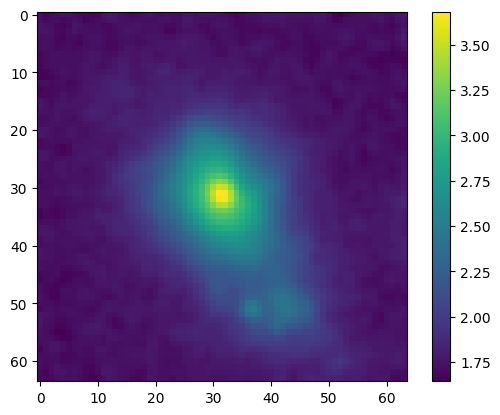

In [41]:
plt.imshow(np.log10(test[1, 0]))
plt.colorbar()
print(np.log10(data.images[0, 0]))

In [60]:
print(data.indices[6294])
print(data.soap_file["SO/500_crit/XRayPhotonLuminosityWithoutRecentAGNHeating"][data.indices[6294]])
print(data.images.shape)
# np.save(p["data_path"] + filename, np.delete(data.images, 6294, axis=0))
# np.save(p["data_path"] + filename + "_halo_indices", np.delete(data.indices, 6294, axis=0))
# np.save(p["data_path"] + filename + "_masses", np.delete(data.masses, 6294, axis=0))

9599996
[0. 0. 0.]
(7290, 2, 64, 64)


(735, 2, 64, 64)
(735, 2, 64, 64)


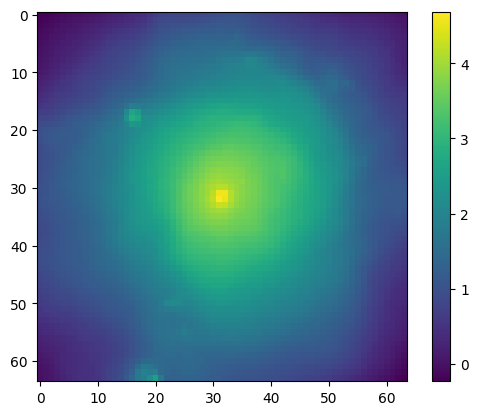

(735, 2, 64, 64)
(735, 2, 64, 64)


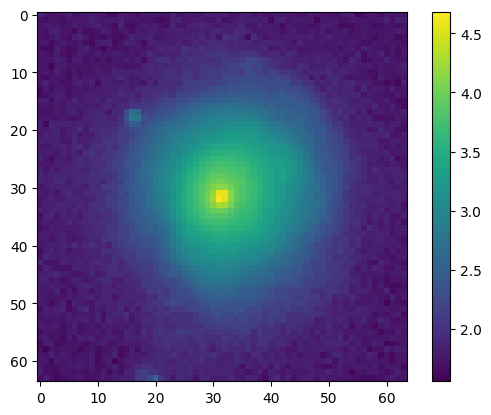

(735, 2, 64, 64)
(735, 2, 64, 64)


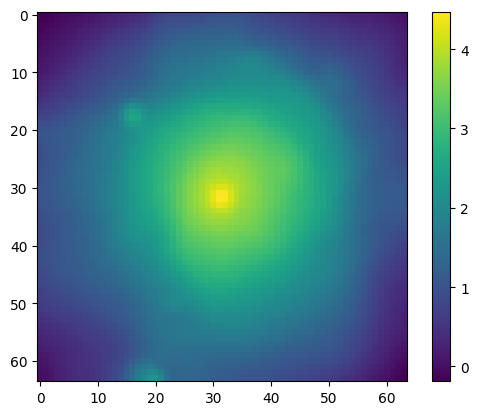

(735, 2, 64, 64)
(735, 2, 64, 64)


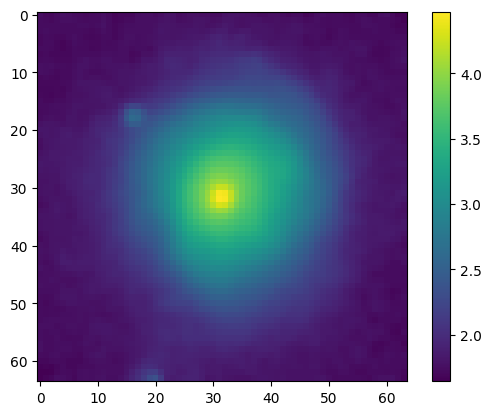

In [26]:
data.load_testset(filename=filename)
plt.imshow(np.log10(data.image_to_observation(False, False)[0,0]))
plt.colorbar()
plt.show()
plt.imshow(np.log10(data.image_to_observation(True, False)[0,0]))
plt.colorbar()
plt.show()
plt.imshow(np.log10(data.image_to_observation(False, True)[0,0]))
plt.colorbar()
plt.show()
plt.imshow(np.log10(data.image_to_observation(True, True)[0,0]))
plt.colorbar()
plt.show()

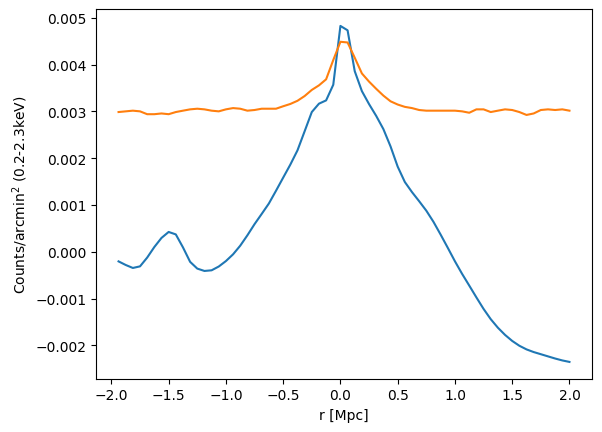

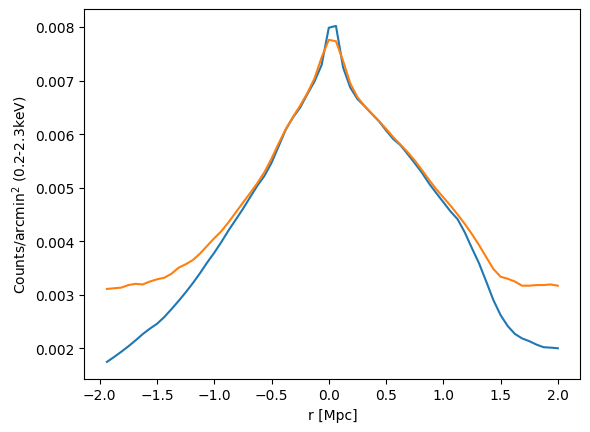

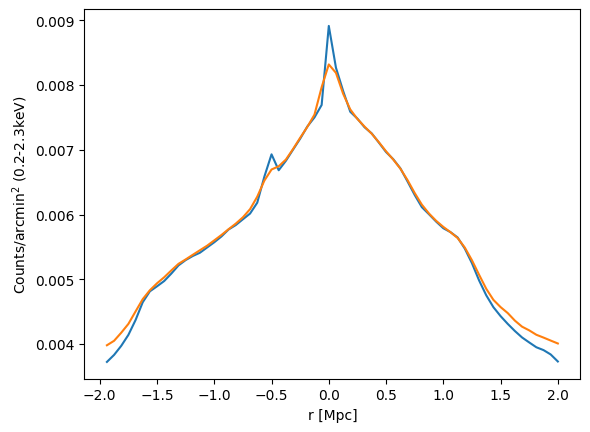

In [39]:
x = (np.arange(64)-31)*4/64
plt.plot(x, np.log10(data.image_to_observation(False, False)[2,0,31])/(fov))
plt.plot(x, np.log10(data.image_to_observation(True, True)[2,0,31])/(fov))
plt.xlabel("r [Mpc]")
plt.ylabel(r"Counts/arcmin$^2$ (0.2-2.3keV)")
plt.show()
plt.plot(x, np.log10(data.image_to_observation(False, False)[0,0,31])/(fov))
plt.plot(x, np.log10(data.image_to_observation(True, True)[0,0,31])/(fov))
plt.xlabel("r [Mpc]")
plt.ylabel(r"Counts/arcmin$^2$ (0.2-2.3keV)")
plt.show()
plt.plot(x, np.log10(data.image_to_observation(False, False)[1,0,31])/(fov))
plt.plot(x, np.log10(data.image_to_observation(True, True)[1,0,31])/(fov))
plt.xlabel("r [Mpc]")
plt.ylabel(r"Counts/arcmin$^2$ (0.2-2.3keV)")
plt.show()

/var/tmp/tol/ipykernel_1566062/4269168053.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data.images[i,1]))


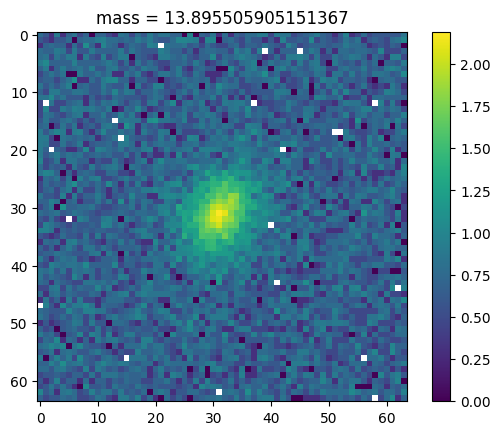

In [258]:
i = 6
plt.imshow(np.log10(data.images[i,1]))
plt.title(f"mass = {np.log10(data.soap_file['SO/500_crit/DarkMatterMass'][data.indices[i]])}")
plt.colorbar()

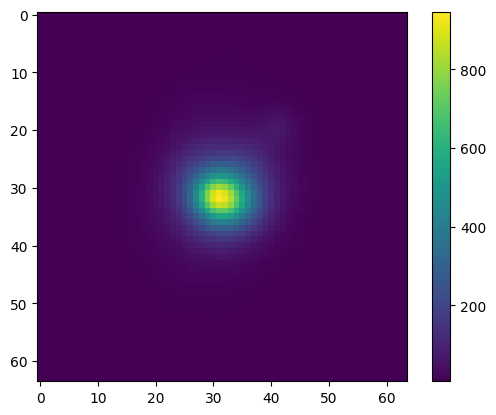

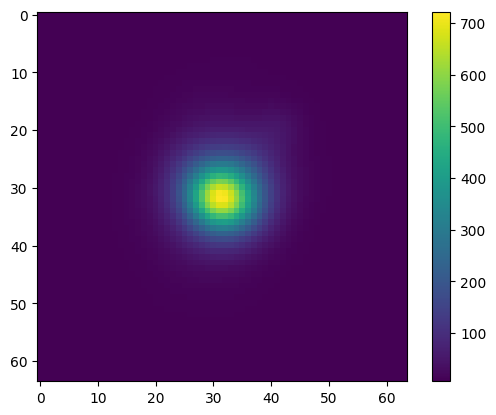

In [59]:
from scipy.ndimage import gaussian_filter
plt.imshow((data.images[0,0]))
plt.colorbar()
plt.show()
test = gaussian_filter(data.images[0, 0], 0.6745*26*64/(60*10))
plt.imshow((test))
plt.colorbar()
plt.show()

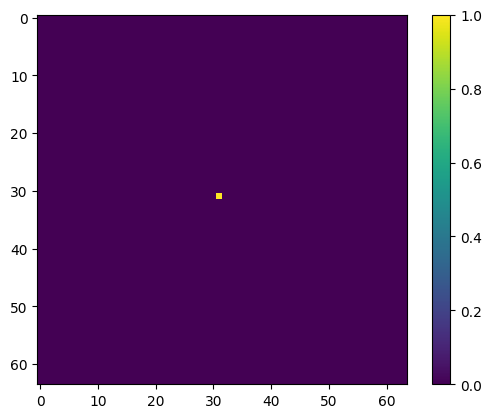

1.0


/var/tmp/tol/ipykernel_2605008/1967461137.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(test3))


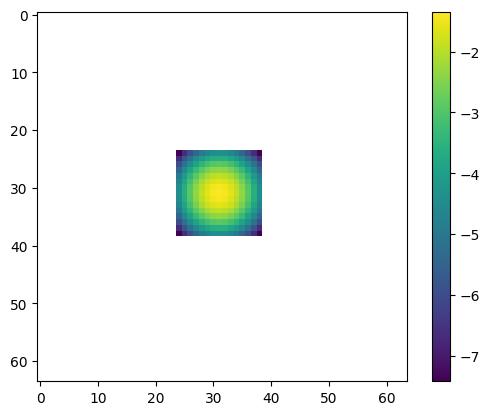

1.0000000000000002


In [60]:
test2 = np.zeros((64, 64))
test2[31, 31] = 1
plt.imshow(test2)
plt.colorbar()
plt.show()
print(test2.sum())
test3 = gaussian_filter(test2, 0.6745*26*64/(60*10))
plt.imshow(np.log10(test3))
plt.colorbar()
plt.show()
print(test3.sum())

In [4]:
print(np.sum(data.soap_file["SO/500_crit/DarkMatterMass"][()] > 1e13))

77885


In [20]:
print(np.sum(data.masses > 1e13))
print(len(data.masses))
print(get_flux_ratio(p))

7359
7359
68.10015470019941
(1.5683788555713668e-52, 23.26705007563791)


[13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3
 14.4 14.5 14.6 14.7 14.8 14.9 15. ]


TypeError: FigureCanvasPdf.print_pdf() got an unexpected keyword argument 'bbox'

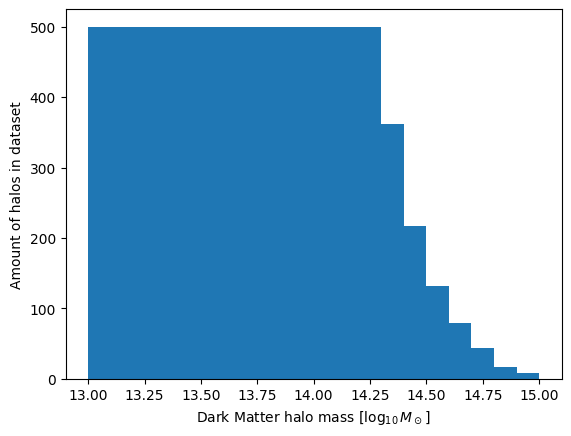

In [19]:
data = Data(p)
data.load_dataset(p_to_filename(p))
logbins = np.linspace(13, 15, 21)
print(logbins)
plt.hist(np.log10(data.masses), bins = logbins)
plt.xlabel(r"Dark Matter halo mass [$\log_{10}M_\odot$]")
plt.ylabel("Amount of halos in dataset")
plt.savefig("mass_distribution.pdf", dpi=200, bbox="tight")
plt.show()

In [11]:
# for model in ["HYDRO_FIDUCIAL", "HYDRO_JETS_published", "HYDRO_STRONG_AGN", "HYDRO_STRONG_JETS_published", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_STRONGEST_AGN", "HYDRO_WEAK_AGN"]:
# for i in range(1, 6):
for model in ["HYDRO_FIDUCIAL"]:
    p["soapfile"] = "halo_properties_0078.hdf5"
    p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
    p["snapshot_folder"] = "snapshots_reduced"
    p["simsize"] = "L2800N5040"
    p["model"] = model
    data = Data(p)
    filename = p_to_filename(p) #+ str(i)
    indices = np.load(p["data_path"] + filename+"1" + "_halo_indices.npy")
    dmmasses = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][()][indices]
    # print(indices.shape)
    # print(masses.shape)
    # print(np.load(p["data_path"] + filename + "_masses.npy").shape)
    
    np.save(p["data_path"] + filename + "_dmmasses", dmmasses)

In [14]:
for i in range(len(data.images)):
    data.images[i][data.images[i] == 0] = 1

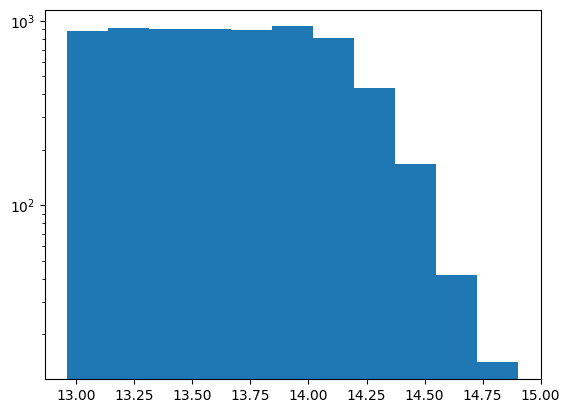

In [40]:
plt.hist(np.log10(data.masses), bins=11)
plt.yscale("log")

In [11]:
###remove image from data and save
print(data.images.shape)
print(data.indices.shape)
data.images = np.delete(data.images, ids_to_remove, axis=0)
data.indices = np.delete(data.indices, ids_to_remove)
print(data.images.shape)
print(data.indices.shape)

(7941, 2, 64, 64)
(7941,)
(7934, 2, 64, 64)
(7934,)


In [57]:
np.save(p["data_path"] + filename, data.images)
np.save(p["data_path"] + filename + "_halo_indices", data.indices)

(array([114.,  86., 120.,  83., 104., 109., 104., 105., 100.,  79., 100.,
        107.,  92., 107.,  93., 126., 115.,  85.,  88.,  83., 108., 101.,
        109.,  94.,  91., 118.,  90.,  98., 111.,  80., 116., 106., 113.,
         87.,  78.,  95., 107., 112.,  92.,  94., 100., 102., 114.,  99.,
         87., 126., 107., 101.,  81.,  83., 111.,  99., 104.,  96.,  93.,
        103., 111., 107.,  99.,  77.,  94., 106., 114., 107.,  80., 118.,
        108.,  91.,  97.,  85., 112., 120.,  82.,  82., 104., 128.,  86.,
        116.,  85.,  85., 126., 106.,  92.,  93.,  83., 109., 111.,  98.,
         94.,  88., 115., 115.,  98.,  81.,  91., 118., 124.,  96.,  82.,
         80.]),
 array([13.00068855, 13.02067947, 13.04067039, 13.06066036, 13.08065128,
        13.1006422 , 13.12063313, 13.14062405, 13.16061497, 13.18060493,
        13.20059586, 13.22058678, 13.2405777 , 13.26056862, 13.28055859,
        13.30054951, 13.32054043, 13.34053135, 13.36052227, 13.38051319,
        13.40050316, 13.42

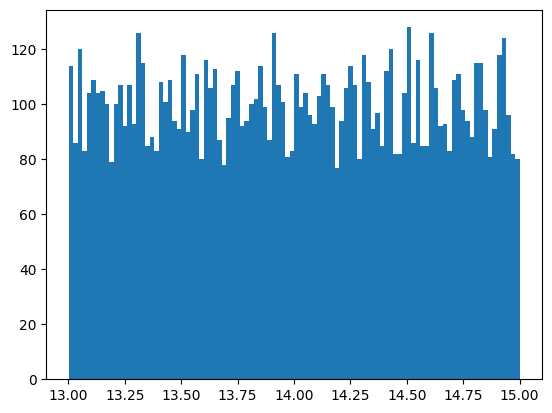

In [20]:
# halo_indices = np.load(p["data_path"] + filename + "_halo_indices" + ".npy")
# print(halo_indices.shape)
# print(data.soap_file[f"{p['selection_type']}/DarkMatterMass"][()][halo_indices])
plt.hist(np.log10(data.soap_file[f"{p['selection_type']}/DarkMatterMass"][()][halo_indices]), bins=100)
# np.save(p["data_path"] + p_to_filename(p) + "_masses", data.soap_file[f"{p['selection_type']}/DarkMatterMass"][()][halo_indices])

In [49]:
###Append rest of data to half-finished data generation
dataset = np.load(p["data_path"] + p_to_filename(p) + "big2" + ".npy")
halo_indices = np.load(p["data_path"] + p_to_filename(p) + "big2" + "_halo_indices" + ".npy")
time_start = time.time()
for sample, halo_index in enumerate(halo_indices):
    if sample < len(data.images):
        continue
    red_flux, blue_flux = data.make_obs(halo_index)
    fluxes = np.append(red_flux, blue_flux).reshape(1, 2, p['resolution'], p['resolution'])
    dataset = np.append(dataset, fluxes).reshape(sample+1, 2, p['resolution'], p['resolution'])
    print(f"Sample {sample} of {len(halo_indices)} done. Time running: {time.time() - time_start}s")

    if sample%100 == 99:
        np.save(p["data_path"] + p_to_filename(p) + "big2_append4", dataset)
np.save(p["data_path"] + p_to_filename(p) + "big2_append4", dataset)

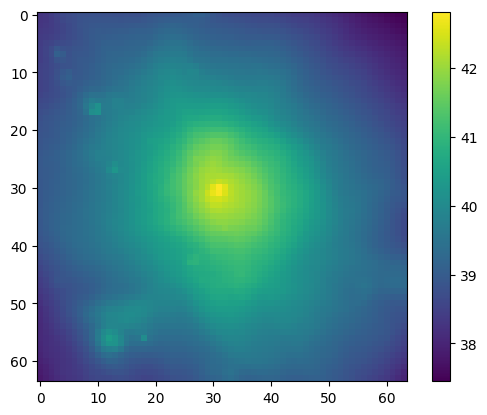

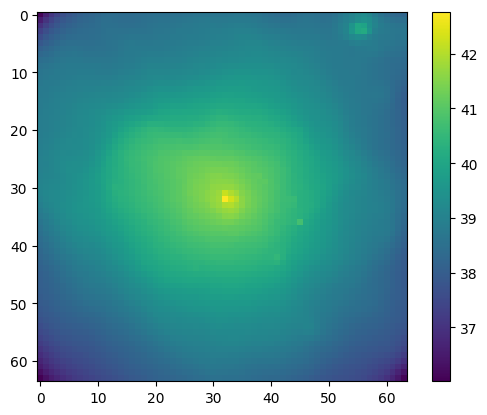

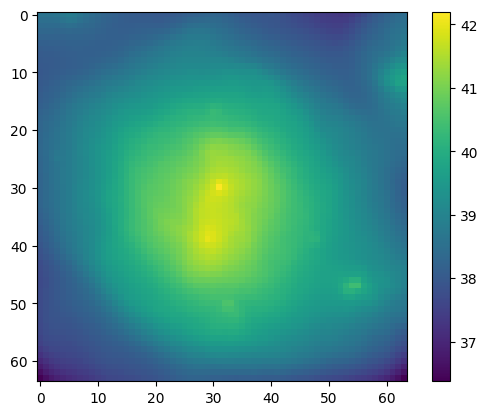

/var/tmp/tol/ipykernel_384111/787402369.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image[0]))


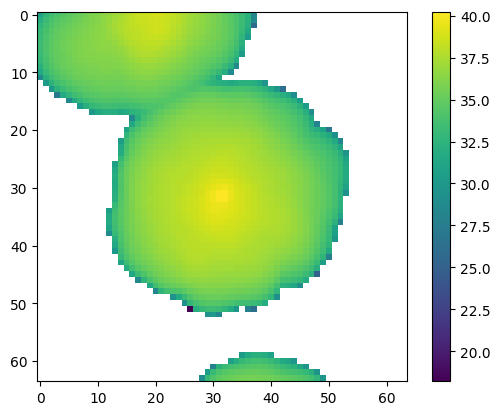

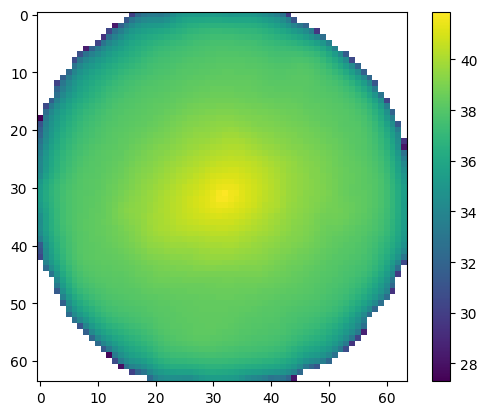

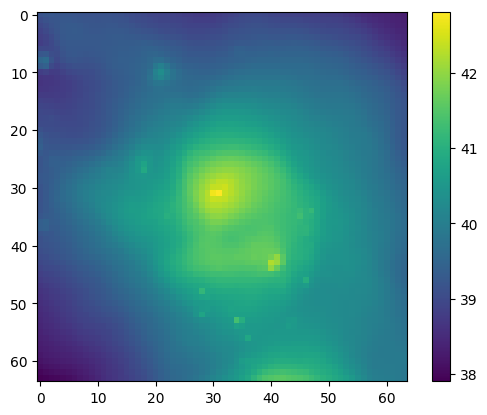

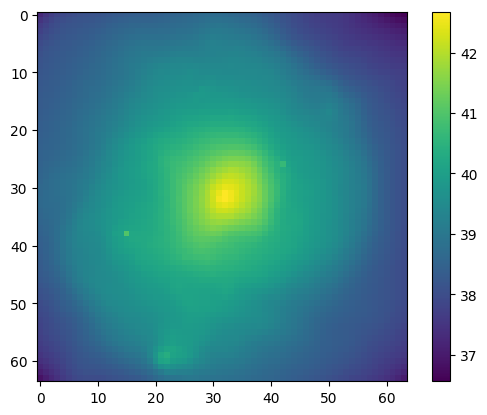

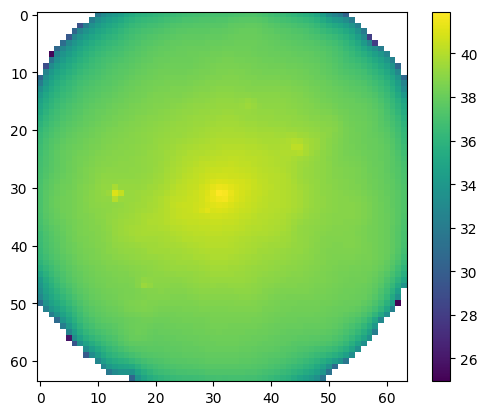

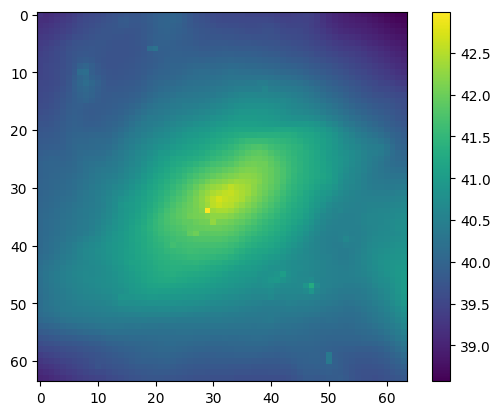

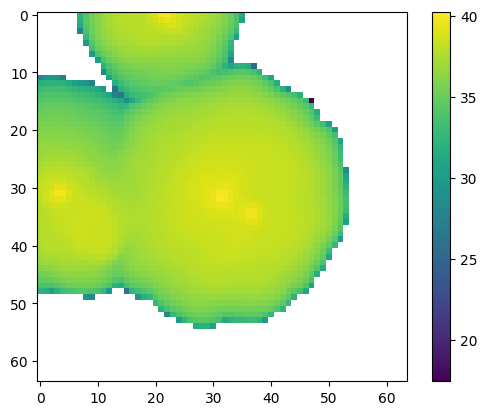

In [22]:
for image in data.images[:10]:
    plt.imshow(np.log10(image[0]))
    plt.colorbar()
    plt.show()

(7941, 2, 64, 64)


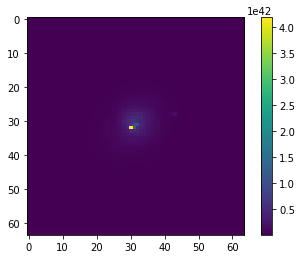

In [69]:
print(data.images.shape)
import matplotlib.pyplot as plt
plt.imshow(data.images[-4, 0])
plt.colorbar()
plt.show()

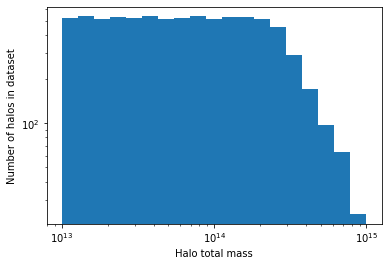

In [20]:
logbins = np.logspace(np.log10(np.min(data.masses)), np.log10(np.max(data.masses)), 20)
plt.hist(data.masses, bins=logbins)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Number of halos in dataset")
plt.xlabel("Halo total mass")
plt.show()

# make single obs data

In [42]:
# p["snapshot"] = "flamingo_0073/flamingo_0073.hdf5"
p["redshift"] = 0.15
p["model"] = "HYDRO_WEAK_AGN"
data = Data(p)
halo_nr = 100


print(np.log10(data.soap_file[f"{p['selection_type']}/DarkMatterMass"][halo_nr]))
low, high = data.make_obs(halo_nr, rotate=True)

13.591428


/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=0.8695652173913047) for all arguments.
  warnings.warn(


234.30643079408776


/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**(-2.0) at a=0.8695652173913047) for all arguments.
  warnings.warn(


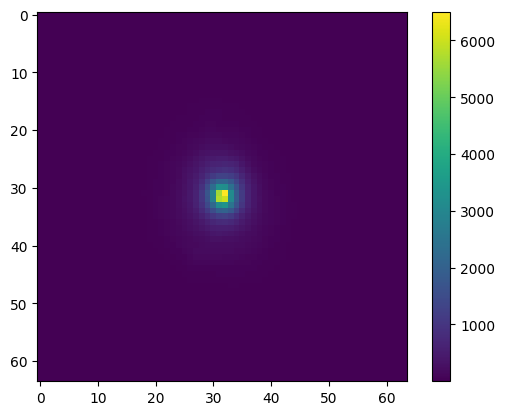

In [22]:
flux_ratio, fov = get_flux_ratio(p)
filepath = open(p['model_path'] + "bgd.json", 'r')
bgd = json.load(filepath)
print(1/(64*64)*bgd["bgd_high"]*fov**2*p["obs_time"] * p["modules"])
plt.imshow((high*flux_ratio*p["obs_time"]))
plt.colorbar()
plt.show()

In [55]:
### linear prediction
halo_nr = 100
low, high = data.make_obs(halo_nr, rotate=True)
print(np.log10(data.soap_file[f"{p['selection_type']}/DarkMatterMass"][halo_nr]))

pixel_size = 4 * 1000 / 64  #4Mpc * 1000kpc/Mpc / 64pixels
r = data.soap_file[f"{data.selection_type}/SORadius"][halo_nr] * 1000 #kpc

radius = r / pixel_size
X, Y = np.ogrid[:p['resolution'], :p['resolution']]
dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
mask_circ = dist_from_center<=radius
print(np.log10(np.sum(low[mask_circ])))
print(np.log10(np.sum(high[mask_circ])))
print(np.log10(np.sum(low)))
print(np.log10(np.sum(high)))

print(np.log10(data.soap_file[f"{data.selection_type}/XRayPhotonLuminosityWithoutRecentAGNHeating"][halo_nr]))

13.591428
51.97532769016503
50.50496647957423
52.18748434888486
50.584324535822354
[52.02164898 50.5653373  51.69831717]


In [13]:
soapfile = h5py.File("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP/halo_properties_0077.hdf5", "r")
mask = sw.mask("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5")

(cosmo_array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], 'erg/s'), cosmo_array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], 'erg/s'))


In [14]:
print(soapfile["VR/StructureType"][12902130])

10


In [57]:
halo_data = data.make_obs(5772976)

(421128,)
[0.57666016 0.57666016 0.57666016 ... 0.8222656  0.8222656  0.8222656 ] dimensionless (Comoving)


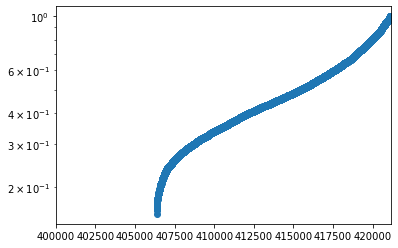

In [85]:
print((halo_data.gas.masses).shape)
print(np.sort(halo_data.gas.last_agnfeedback_scale_factors)[-4000:-1000])
plt.scatter(range(len(halo_data.gas.masses)), np.sort(halo_data.gas.last_agnfeedback_scale_factors))
# plt.xscale("log")
plt.xlim(400000, 421128)
plt.yscale("log")

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'black_holes', 'create_particle_datasets', 'dark_matter', 'filename', 'gas', 'get_metadata', 'get_units', 'mask', 'metadata', 'neutrinos', 'stars', 'units']


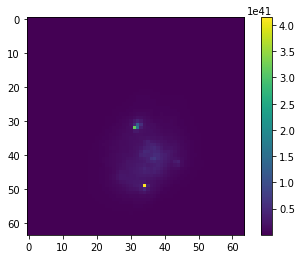

In [56]:
for i in range(5772976, 5772976+1):
    red_flux, blue_flux = data.make_obs(i)
    plt.imshow(red_flux)
    plt.colorbar()
    plt.show()

In [24]:
# def make_obs(halo_index=0):
#     print(soapfile["SO/500_crit/XRayLuminosity"][halo_index])
#     position = soapfile["SO/500_crit/CentreOfMass"][halo_index] * unyt.Mpc
#     # radius = soapfile["SO/500_crit/SORadius"][halo_index] * unyt.Mpc
#     radius = 2*unyt.Mpc
#     load_box = [[position[0] - radius, position[0] + radius], 
#                 [position[1] - radius, position[1] + radius], 
#                 [position[2] - radius, position[2] + radius]]
#     mask.constrain_spatial(load_box)
#     halo_data = sw.load("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077/flamingo_0077.hdf5", mask=mask)

#     halo_mask = halo_data.gas.last_agnfeedback_scale_factors < 0.999
    

#     halo_data.gas.flux = halo_data.gas.xray_luminosities.erosita_low
#     flux = sw.visualisation.projection.project_gas(
#         halo_data,
#         resolution=64, 
#         project="flux", 
#         region=[position[0] - radius, position[0] + radius, position[1] - radius, position[1] + radius],
#         parallel = True,
#         mask = halo_mask
#     )
#     flux = np.float64(flux)
#     flux.convert_to_units(unyt.erg/unyt.s / unyt.kpc**2)

#     return flux

[8.67039471e+41 5.27437669e+40 6.16591649e+41]
7.736604162846131e+43 erg/(kpc**2*s) (Comoving)


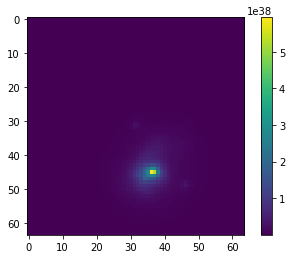

# test compton-y

In [2]:
p["cosmology"] = "HYDRO_PLANCK"
data = Data(p)

In [3]:
mask = sw.mask(data.sw_path)
position = data.soap_file[f"{p['selection_type']}/CentreOfMass"][0] * unyt.Mpc
radius = p['obs_radius'] * unyt.Mpc
load_box = [[position[0] - radius, position[0] + radius], 
            [position[1] - radius, position[1] + radius], 
            [position[2] - radius, position[2] + radius]]
mask.constrain_spatial(load_box)

halo_data = sw.load(data.sw_path, mask=mask)

In [6]:
# for i in dir(halo_data.gas.compton_yparameters):
#     print(i)
print(halo_data.gas.xray_photon_luminosities.erosita_low[:20])
print(halo_data.gas.xray_luminosities.erosita_low[:20])
print(halo_data.gas.compton_yparameters)

[1.31254699e+64 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.92444936e+63 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.59857215e+63
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] 0.00102271448879616/Gyr (Comoving)
[39.125    0.       0.       0.      70.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.      31.96875
  0.       0.       0.       0.     ] 10.697030298874*Mpc**2*Msun/Gyr**3 (Comoving)
[1.37134748e-12 5.75095527e-14 4.49085213e-14 ... 2.13162821e-13
 2.82796009e-12 4.32542890e-13] Mpc**2 (Comoving)


In [47]:
d = halo_data.metadata.cosmology
print(halo_data.metadata.cosmology)
print(d["Universe age [internal units]"]*1000 - 0.015)
print( (d["Omega_m"] / d["Omega_lambda"] * np.sinh(3.0/2.0 * np.sqrt(d["Omega_lambda"]) * d["H0 [internal units]"] * (d["Hubble time [internal units]"] - 0.000015))**2)**(1./3.))
# print(dir(halo_data.metadata.cosmology.values))
# print(dir(astropy))

{'Cosmological run': array([1], dtype=int32), 'Critical density [internal units]': array([12.87106552]), 'H [internal units]': array([68.09999997]), 'H0 [internal units]': array([68.09999997]), 'Hubble time [internal units]': array([0.01468429]), 'Lookback time [internal units]': array([9.02056208e-16]), 'M_nu_eV': array([0.06]), 'N_eff': array([3.04400163]), 'N_nu': array([1.]), 'N_ur': array([2.0308]), 'Omega_b': array([0.0486]), 'Omega_cdm': array([0.256011]), 'Omega_g': array([5.33243487e-05]), 'Omega_k': array([2.5212783e-09]), 'Omega_lambda': array([0.693922]), 'Omega_m': array([0.304611]), 'Omega_nu': array([0.00138908]), 'Omega_nu_0': array([0.00138908]), 'Omega_r': array([7.79180471e-05]), 'Omega_ur': array([2.45936984e-05]), 'Redshift': array([0.]), 'Scale-factor': array([1.]), 'T_CMB_0 [K]': array([2.7255]), 'T_CMB_0 [internal units]': array([2.7255]), 'T_nu_0 [eV]': array([0.00016819]), 'T_nu_0 [internal units]': array([1.9517578]), 'Universe age [internal units]': array([0

# gas fractions


In [2]:
p["soapfile"] = "halo_properties_0077.hdf5"
p["snapshot"] = "flamingo_0077/flamingo_0077.hdf5"
p["snapshot_folder"] = "snapshots"
p["simsize"] = "L1000N1800"
data = Data(p)
gasmass = data.soap_file["SO/500_crit/GasMass"][()]
totalmass = data.soap_file["SO/500_crit/DarkMatterMass"][()]
indices = (gasmass > 0)*(totalmass>0)*(totalmass>1e13)*(totalmass<1e15)
# indices = np.logical_and(gasmass > 0, totalmass > 0)
gasmass = gasmass[indices]
totalmass = totalmass[indices]
massfractions = gasmass / totalmass
print(indices.shape)

(13235708,)


In [4]:
print(gasmass.shape)

(92000,)


Text(0, 0.5, 'Gas fraction')

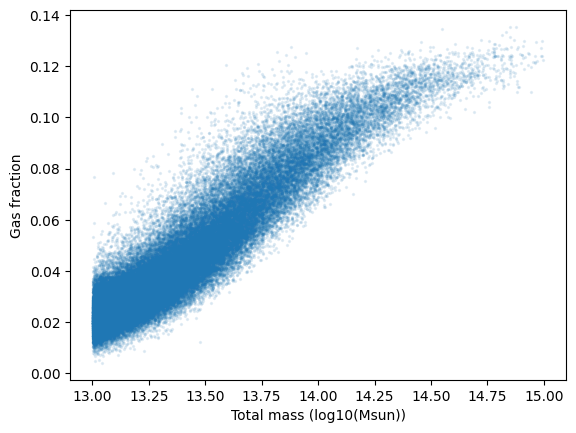

In [54]:
plt.scatter(np.log10(totalmass), massfractions, s=2, alpha=0.1)
plt.xlabel("Total mass (log10(Msun))")
plt.ylabel("Gas fraction")

In [43]:
bins = np.logspace(13, 15, 20)

gasfrac = []
mass = []
for i in range(len(bins)-1):
    indices = np.logical_and(totalmass > bins[i], totalmass < bins[i+1])

    gasfrac.append(np.median(massfractions[indices]))
    mass.append(np.median(totalmass[indices]))
    

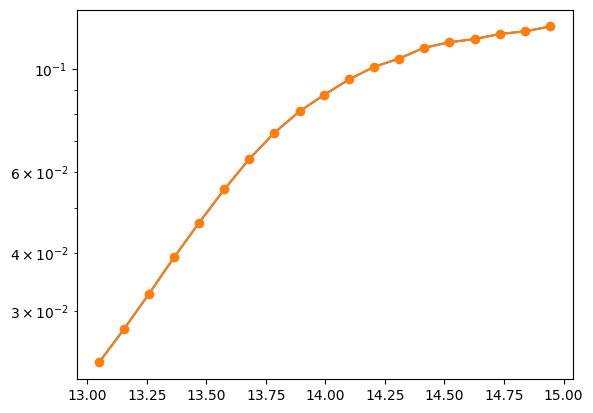

In [48]:
plt.plot(np.log10(mass), gasfrac)
plt.plot(np.log10(mass2), gasfrac2, marker="o")

# plot image examples

In [87]:
p["redshift"] = 0.15
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
filename = p_to_filename(p)
data.load_dataset(filename=filename)
print(data.images.shape)
psfs, photons = data.image_to_observation()

(7359, 2, 64, 64)


In [111]:
print(np.log10(data.masses[0]))

14.343855


In [ ]:
for i in np.arange(90, 120):
    plt.imshow(np.log10(data.images[i, 1]))
    plt.colorbar()
    plt.title(f"Index {i}, mass {np.log10(data.masses[i])}")
    plt.show()

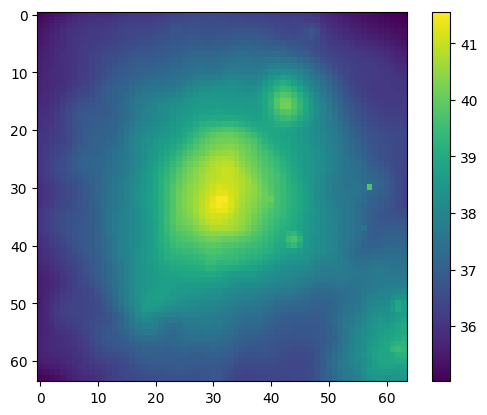

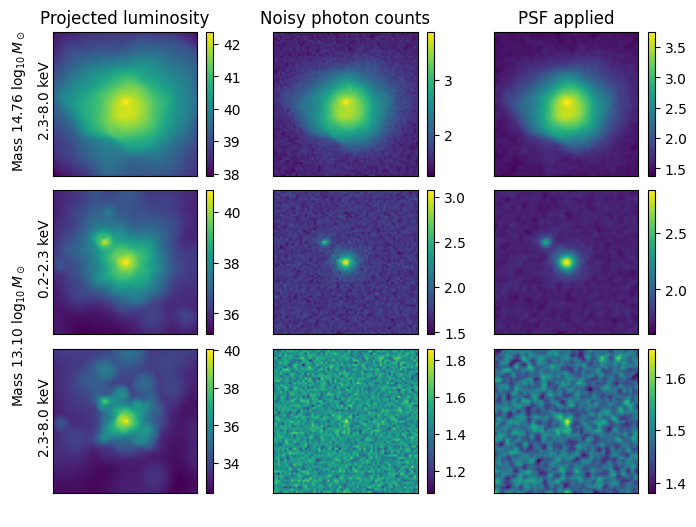

In [193]:
plt.imshow(np.log10(data.images[26,1]))
plt.colorbar()
plt.show()
fig, axs = plt.subplots(3, 3)
indices = [1, 111, 111]
channels = [1, 0, 1]
for row in range(3):
    col1 = axs[row, 0].imshow(np.log10(data.images[indices[row],channels[row]]))
    fig.colorbar(col1, ax=axs[row, 0])
    axs[row,0].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    col2 = axs[row, 1].imshow(np.log10(photons[indices[row],channels[row]]))
    fig.colorbar(col2, ax=axs[row, 1])
    axs[row,1].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    col3 = axs[row, 2].imshow(np.log10(psfs[indices[row],channels[row]]))
    fig.colorbar(col3, ax=axs[row, 2])
    axs[row,2].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axs[0, 0].set_title("Projected luminosity")
axs[0, 1].set_title("Noisy photon counts")
axs[0, 2].set_title("PSF applied")
# axs[0, 0].set_ylabel(f"Mass {np.log10(data.masses[indices[0]]):.02f}"+r" $\log_{10} M_\odot$")
# axs.set_ylabel(f"Mass {np.log10(data.masses[indices[1]]):.02f}"+r" $\log_{10} M_\odot$")
fig.text(-0.03, 0.35, f"Mass {np.log10(data.masses[indices[1]]):.02f}"+r" $\log_{10} M_\odot$", ha="center", va="center", rotation="vertical")
fig.text(0.01, 0.84, "2.3-8.0 keV", ha="center", va="center", rotation="vertical")
fig.text(0.01, 0.18, "2.3-8.0 keV", ha="center", va="center", rotation="vertical")
fig.text(0.01, 0.51, "0.2-2.3 keV", ha="center", va="center", rotation="vertical")
fig.text(-0.03, 0.84, f"Mass {np.log10(data.masses[indices[0]]):.02f}"+r" $\log_{10} M_\odot$", ha="center", va="center", rotation="vertical")
# axs[1, 0].imshow(np.log10(data.images[26,1]))
# axs[1, 1].imshow(np.log10(photons[26,1]))
# axs[1, 2].imshow(np.log10(psfs[26,1]))
fig.tight_layout(pad=-1)
plt.savefig("Image comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()